In [11]:
!pip install tensorflow-text==2.6

  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30702 sha256=169a785456dbb60f760080cb602e7b9f4472581d42665e6dbfd0ee3b619708d3
  Stored in directory: c:\users\zhizh\appdata\local\pip\cache\wheels\f1\60\77\22b9b5887bd47801796a856f47650d9789c74dc3161a26d608
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4829 sha256=e0a8863819443926aca95a61c8ffe54a6451fe7316bf03236d963f3144fe23b5
  Stored in directory: c:\users\zhizh\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501
Successfully built clang termcolor
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 3.10.0
    Uninstalling importlib-metadata-3.10.0:
      Successfully uninstalled importlib-metadata-3.10.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.1
    Uninstalling numpy-1.20.1:
      Successfully uninstalled numpy-1.20.1
  Attempting uninstall: h5py
    Found existing inst

In [20]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from wordcloud import WordCloud

# Preprocessing and evaluation
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
df = pd.read_csv('reviews.csv')
df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Time_submitted  61594 non-null  object
 1   Review          61594 non-null  object
 2   Rating          61594 non-null  int64 
 3   Total_thumbsup  61594 non-null  int64 
 4   Reply           216 non-null    object
dtypes: int64(2), object(3)
memory usage: 2.3+ MB


In [16]:
#set color for data visualization
sns.set(rc={"axes.facecolor":"#e6ffed","figure.facecolor":"#e6ffed", "grid.color":"#99e2b4",
            "axes.edgecolor":"#99e2b4", "axes.labelcolor":"#195e2d", "xtick.color":"#195e2d",
            "ytick.color":"#195e2d"})

# ['#4a7c59', '#68b0ab', '#8fc0a9', '#c8d5b9', '#faf3dd']
palettes = ['#eee82c', '#91cb3e', '#53a548', '#4c934c', '#19381f']
cmap = colors.ListedColormap(['#137547', '#2a9134', '#3fa34d', '#5bba6f', '#19381f'])

C:\Users\zhizh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Rating of Replied Reviews')

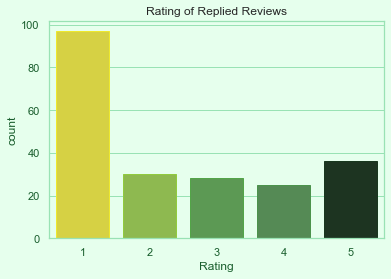

In [17]:
reply = df[~df['Reply'].isna()]

ax = sns.countplot(reply['Rating'], palette=palettes, edgecolor=palettes)
ax.set_title('Rating of Replied Reviews')

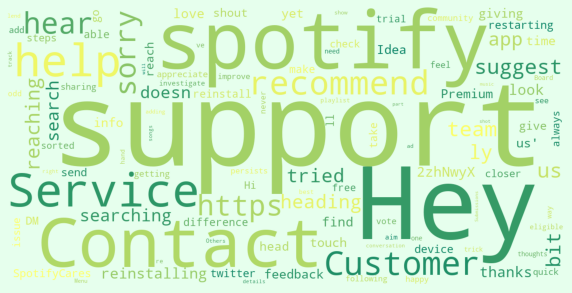

In [21]:
plt.figure(figsize=(10,10))
wc = WordCloud(max_words=1000, min_font_size=10, height=600, width=1200, collocations=False,
               background_color='#e6ffed', colormap='summer').generate(' '.join(reply['Reply']))

plt.axis('off')
plt.imshow(wc)

In [22]:
def top_words(text):
    word = pd.DataFrame(wc.process_text(''.join(text)).items()).sort_values(1, ascending=False)
    
    print('Top 5 words that appear most frequently:\n')
    for i in range(5):
        item = word.iloc[i]
        print(item[0] + '\t--> ' + str(item[1]))

In [23]:
top_words(reply['Reply'])

Top 5 words that appear most frequently:

support	--> 204
Hey	--> 194
spotify	--> 166
Contact	--> 118
Service	--> 115


In [24]:
df['Time_submitted'] = pd.to_datetime(df['Time_submitted'])

df['Date'] = df['Time_submitted'].apply(lambda x: x.date())

reviews_per_day = df.groupby(df['Date']).count()['Review']
reviews_per_day = reviews_per_day.reset_index()
reviews_per_day['Month'] = reviews_per_day['Date'].apply(lambda x: x.month)

In [25]:
reviews_per_day.rename(columns={'Review':'Total_review'}, inplace=True)
reviews_per_day.head()

,Date,Total_review,Month
0,2022-01-01,46,1
1,2022-01-02,43,1
2,2022-01-03,66,1
3,2022-01-04,56,1
4,2022-01-05,64,1


Text(0.5, 1.0, 'Total Review per Day')

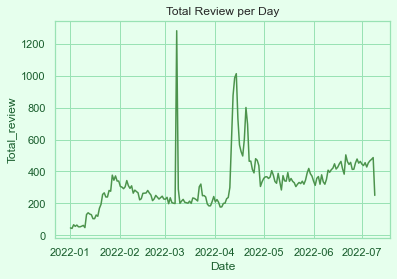

In [26]:
ax = sns.lineplot(data=reviews_per_day, x='Date', y='Total_review', color='#4c934c')
ax.set_title('Total Review per Day')

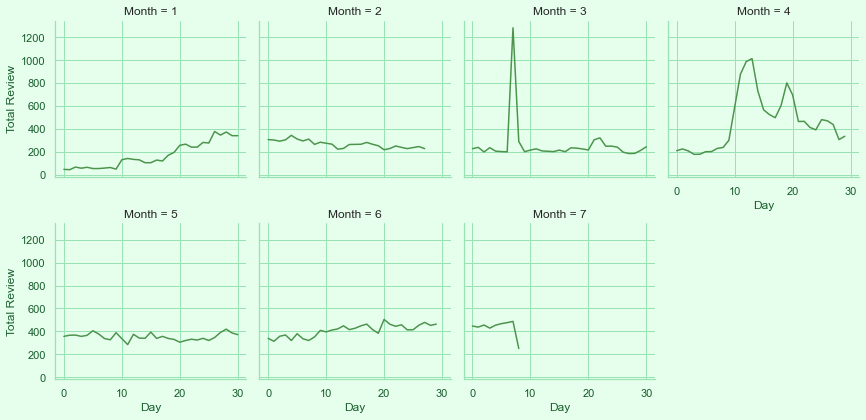

In [27]:
g = sns.FacetGrid(data=reviews_per_day, col='Month', col_wrap=4)
g.map(plt.plot, 'Total_review', color='#4c934c')
g.set_axis_labels(x_var='Day', y_var='Total Review')

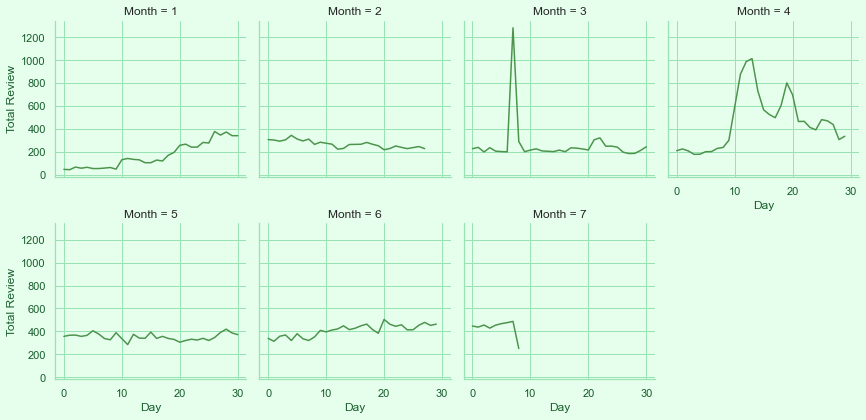

In [28]:
g = sns.FacetGrid(data=reviews_per_day, col='Month', col_wrap=4)
g.map(plt.plot, 'Total_review', color='#4c934c')
g.set_axis_labels(x_var='Day', y_var='Total Review')

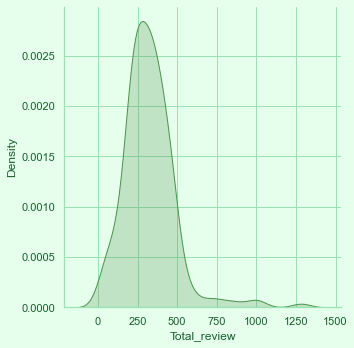

In [29]:
ax = sns.displot(data=reviews_per_day, x='Total_review', kind='kde', fill=True, color='#4c934c')

In [30]:
# Let's change the rating to be more general and easier to understand
def rating(score):
    if score > 3:
        return 'Good'
    elif score == 3:
        return 'Netral'
    else:
        return 'Bad'

Text(0.5, 1.0, 'Rating Distribution Across Dataset')

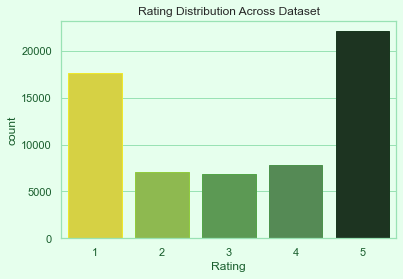

In [31]:
ax = sns.countplot(data=df, x='Rating', palette=palettes, edgecolor=palettes)
ax.set_title('Rating Distribution Across Dataset')

Text(0.5, 1.0, 'Rating Distribution Across Dataset\nAfter Transformation')

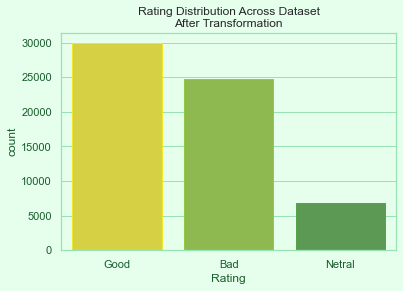

In [32]:
df['Rating'] = df['Rating'].apply(rating)
ax = sns.countplot(data=df, x='Rating', palette=palettes, edgecolor=palettes)
ax.set_title('Rating Distribution Across Dataset\nAfter Transformation')

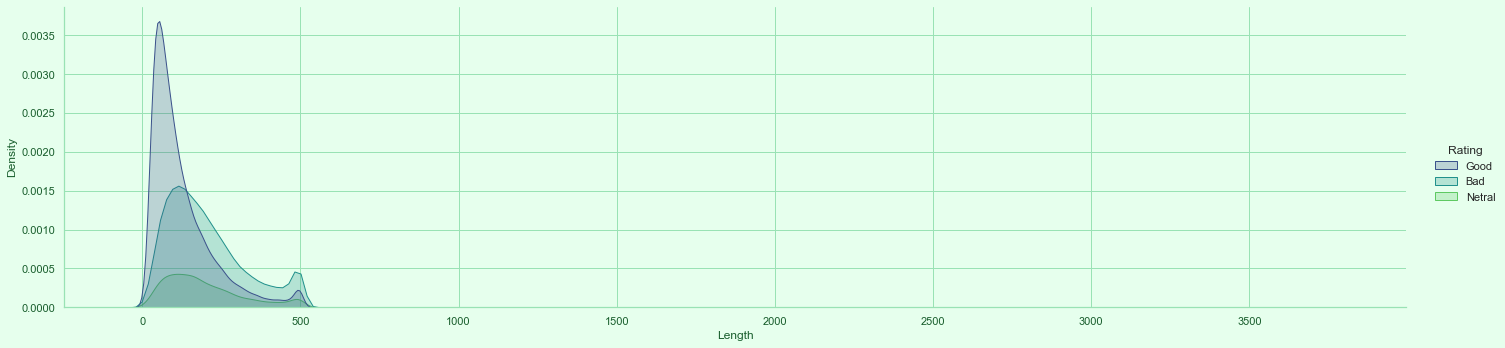

In [33]:
df['Length'] = df['Review'].apply(len)
ax = sns.displot(data=df, x='Length', hue='Rating', kind='kde', fill=True, aspect=4, palette='viridis')

Text(0.5, 1.0, 'Distribution of review Length\nfor Each Rating')

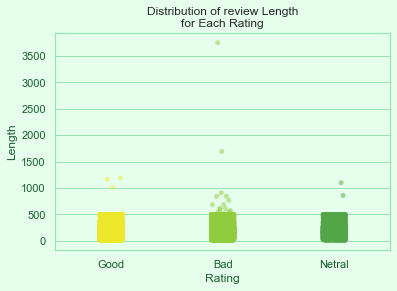

In [34]:
ax = sns.stripplot(data=df, x='Rating', y='Length', alpha=0.5, palette=palettes, edgecolor=palettes)
ax.set_title('Distribution of review Length\nfor Each Rating')

Text(0.5, 1.0, 'Average of review Length\nfor Each Rating')

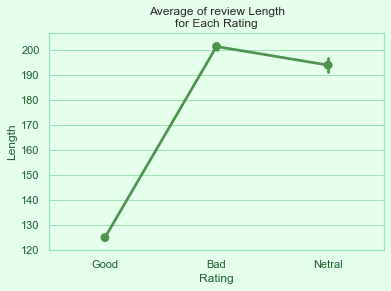

In [35]:
ax = sns.pointplot(data=df, x='Rating', y='Length', color='#4c934c')
ax.set_title('Average of review Length\nfor Each Rating')

In [36]:
max_thumb = df['Total_thumbsup'].max()
print(df[df['Total_thumbsup'] == max_thumb].iloc[0]['Review'])

The app is very good. I got to explore many new songs. However, I took out a star because of a few reasons. First:- It sometimes lags and won't show the music dialog box on your screen or in the app and for this I have to restart it. Second:- I cannot delete my history on phone. Third:- I cannot shuffle playlists or Albums. They have to play on the fixed sequence. Fourth:- I cannot see which song is going to play next if it's a radio and Fifth:- Sometimes the song stops and doesn't start radio


Text(8, -0.2, 'Mean: 7.65')

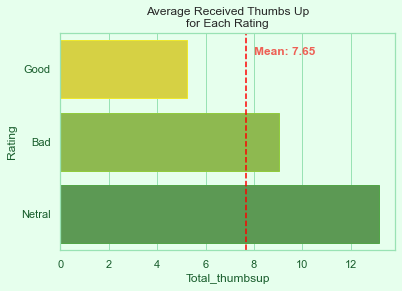

In [37]:
mean_thumb = df['Total_thumbsup'].mean()

ax = sns.barplot(data=df, y='Rating', x='Total_thumbsup', orient='h', ci=None, palette=palettes, edgecolor=palettes)
ax.set_title('Average Received Thumbs Up\nfor Each Rating')
plt.axvline(mean_thumb, color='red', ls='--')
plt.text(x=8, y=-0.2, s='Mean: ' + str(round(mean_thumb, 2)), color='#ee6055', weight='bold')

Text(0.5, 1.0, 'Distribution of Received Thumbs Up\nfor Each Rating')

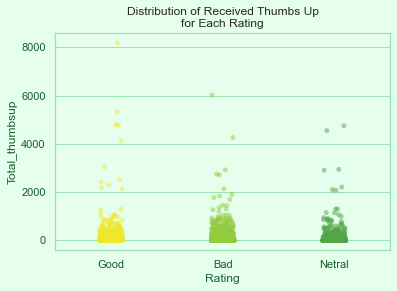

In [38]:
ax = sns.stripplot(data=df, x='Rating', y='Total_thumbsup', palette=palettes, edgecolor=palettes, alpha=0.5)
ax.set_title('Distribution of Received Thumbs Up\nfor Each Rating')

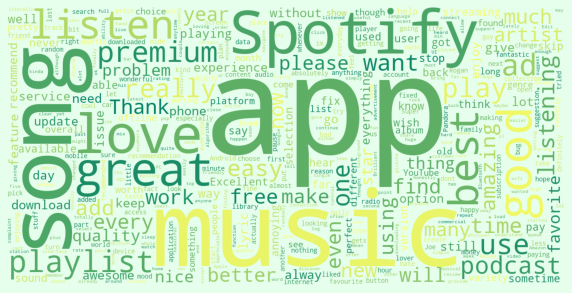

In [39]:
# Most popular word for good review
good = df[df['Rating'] == 'Good']['Review']

plt.figure(figsize=(10,10))
wc = WordCloud(max_words=1000, min_font_size=10, height=600, width=1200, collocations=False,
               background_color='#e6ffed', colormap='summer').generate(' '.join(good))

plt.axis('off')
plt.imshow(wc)

In [40]:
top_words(good)

Top 5 words that appear most frequently:

app	--> 15681
music	--> 14881
song	--> 10608
Spotify	--> 8621
love	--> 6909


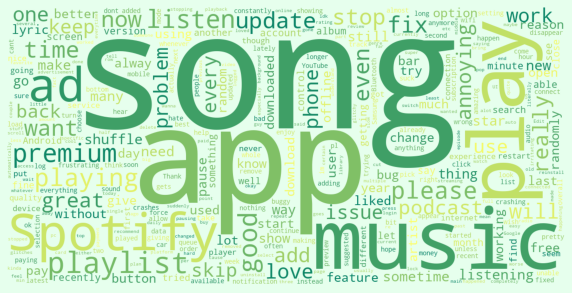

In [41]:
# Most popular word for netral review
netral = df[df['Rating'] == 'Netral']['Review']

plt.figure(figsize=(10,10))
wc = WordCloud(max_words=1000, min_font_size=10, height=600, width=1200, collocations=False,
               background_color='#e6ffed', colormap='summer').generate(' '.join(netral))

plt.axis('off')
plt.imshow(wc)

In [42]:
top_words(netral)

Top 5 words that appear most frequently:

song	--> 4993
app	--> 4125
music	--> 2322
play	--> 2032
Spotify	--> 1837


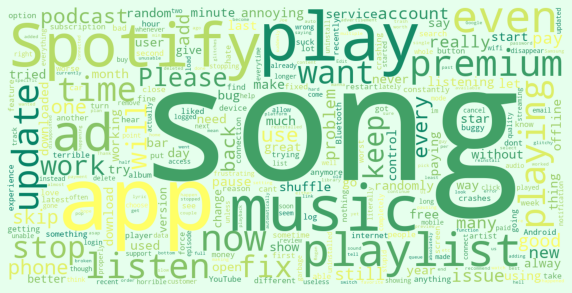

In [43]:
# Most popular word for bad review
bad = df[df['Rating'] == 'Bad']['Review']

plt.figure(figsize=(10,10))
wc = WordCloud(max_words=1000, min_font_size=10, height=600, width=1200, collocations=False,
               background_color='#e6ffed', colormap='summer').generate(' '.join(bad))

plt.axis('off')
plt.imshow(wc)

In [44]:
top_words(bad)

Top 5 words that appear most frequently:

song	--> 16766
app	--> 16445
play	--> 8867
music	--> 7745
Spotify	--> 7381


In [45]:
df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply,Date,Length
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",Good,2,NaN,2022-07-09,112
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,Good,1,NaN,2022-07-09,86
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",Good,0,NaN,2022-07-09,106
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,Bad,1,NaN,2022-07-09,47
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,Bad,1,NaN,2022-07-09,100


In [46]:
df_final = df[['Review', 'Rating', 'Length']]

In [47]:
# Total word in dataset before cleaning
length = df_final['Length'].sum()

In [48]:
print('Original:')
print(df['Review'][7])
print()

sentence = []
for word in df['Review'][7].split():
    stemmer = SnowballStemmer('english')
    sentence.append(stemmer.stem(word))
print('Stemming:')
print(' '.join(sentence))
print()

sentence = []
for word in df['Review'][7].split():
    lemmatizer = WordNetLemmatizer()
    sentence.append(lemmatizer.lemmatize(word, 'v'))
print('Lemmatization:')
print(' '.join(sentence))

Original:
Still extremely slow when changing storage to external sd card.. I'm convinced this is done on purpose, spotify knows of this issue and has done NOTHING to solve it! Over time I have changed sd cards, each being faster in read, write speeds(all samsung brand). And please add "don't like song" so it will never appear again in my searches or playlists.

Stemming:
still extrem slow when chang storag to extern sd card.. i'm convinc this is done on purpose, spotifi know of this issu and has done noth to solv it! over time i have chang sd cards, each be faster in read, write speeds(al samsung brand). and pleas add "don't like song" so it will never appear again in my search or playlists.



LookupError: 
**********************************************************************
  Resource [93mwordnet[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('wordnet')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/wordnet[0m

  Searched in:
    - 'C:\\Users\\zhizh/nltk_data'
    - 'C:\\Users\\zhizh\\anaconda3\\nltk_data'
    - 'C:\\Users\\zhizh\\anaconda3\\share\\nltk_data'
    - 'C:\\Users\\zhizh\\anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\zhizh\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************
